# verifying wind speed
this notebook serves to prove or disprove that the u and v calculated windspeed is the same as the surface wind speed variable in CMIP6 speed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [2]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')

In [3]:
#spatial weight function
def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """
    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

# cm4 wind speed 

In [4]:
##importing Surface Wind data from google cloud. Amon
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_sfw = df.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'sfcWind'& table_id == 'Amon'")

#df is define and ds is store

In [5]:
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_sfw.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_sfw = xr.open_zarr(mapper, consolidated=True)


In [6]:
wind_speed=ds_sfw.sfcWind #isolating surface windspeed array

In [7]:
wind_speed

<xarray.DataArray 'sfcWind' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-sfcWind, shape=(1980, 180, 288), dtype=float32, chunksize=(327, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

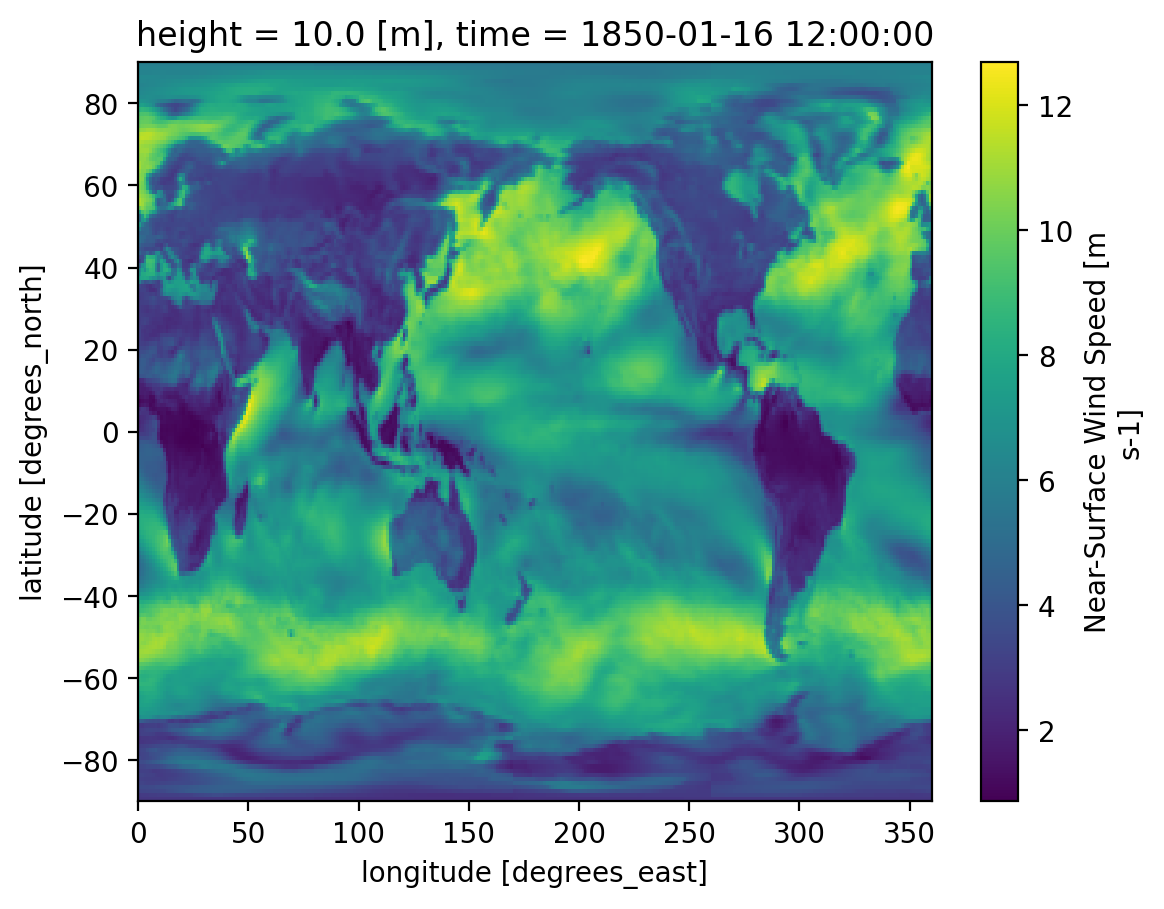

In [8]:
wind_speed.isel(time=0).plot() # verifying the height at which this wind speed is being recorded

In [9]:
wind_speed #looking at the contents of the surface wind array

<xarray.DataArray 'sfcWind' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-sfcWind, shape=(1980, 180, 288), dtype=float32, chunksize=(327, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [10]:
#slicing time for the end of the historical simulation, averaging it, and slicing for the south pole lats
overall_cm4_speed_95_2014=wind_speed.sel(time=slice('1995-01-16','2014-12-16'))
overall_cm4_speed_95_2014

<xarray.DataArray 'sfcWind' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(222, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [12]:
#creating a seasonal wind speed by grouping
sfw_seasonal=wind_speed.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time')
sfw_seasonal

<xarray.DataArray 'sfcWind' (season: 4, lat: 35, lon: 288)>
dask.array<stack, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [13]:
sfw_cm4_summer=sfw_seasonal.sel(season='DJF')
sfw_cm4_winter=sfw_seasonal.sel(season='JJA')
sfw_cm4_spring=sfw_seasonal.sel(season='SON')
sfw_cm4_fall=sfw_seasonal.sel(season='MAM')

In [14]:
sfw_cm4_summer

<xarray.DataArray 'sfcWind' (lat: 35, lon: 288)>
dask.array<getitem, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    season   <U3 'DJF'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [15]:
lat_CM4_historical = overall_cm4_speed_95_2014.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_historical = overall_cm4_speed_95_2014.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4_historical,lon_CM4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_historical = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(overall_cm4_speed_95_2014.coords['lat'],\
                                                        overall_cm4_speed_95_2014.coords['lon']))

In [16]:
weights_cm4=areacell_CM4_historical

In [17]:
weight_ross_CM4_historical=(mask_CM4.ross_CM4*overall_cm4_speed_95_2014).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_filchner_CM4_historical=(mask_CM4.filchner_CM4*overall_cm4_speed_95_2014).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_peninsula_CM4_historical= (mask_CM4.peninsula_CM4*overall_cm4_speed_95_2014).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_loweast_CM4_historical= (mask_CM4.loweast_CM4*overall_cm4_speed_95_2014).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_lowwest_CM4_historical= (mask_CM4.lowwest_CM4*overall_cm4_speed_95_2014).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_plateau_CM4_historical= (mask_CM4.plateau_CM4*overall_cm4_speed_95_2014).weighted(weights_cm4).mean(dim=['lat','lon'])

In [18]:
weight_ross_cm4_annual_historical = ml.util.annual_average(weight_ross_CM4_historical,tcoord='time')
weight_filchner_cm4_annual_historical= ml.util.annual_average(weight_filchner_CM4_historical, tcoord='time')
weight_peninsula_cm4_annual_historical=ml.util.annual_average(weight_peninsula_CM4_historical, tcoord='time')
weight_loweast_cm4_annual_historical=ml.util.annual_average(weight_loweast_CM4_historical, tcoord='time')
weight_lowwest_cm4_annual_historical=ml.util.annual_average(weight_lowwest_CM4_historical, tcoord='time')
weight_plateau_cm4_annual_historical=ml.util.annual_average(weight_plateau_CM4_historical, tcoord='time')

In [19]:
cm4_his_ross_wind=weight_ross_cm4_annual_historical.mean(dim='time')
cm4_his_filch_wind=weight_filchner_cm4_annual_historical.mean(dim='time')
cm4_his_pen_wind=weight_peninsula_cm4_annual_historical.mean(dim='time')
cm4_his_east_wind=weight_loweast_cm4_annual_historical.mean(dim='time')
cm4_his_west_wind=weight_lowwest_cm4_annual_historical.mean(dim='time')
cm4_his_plat_wind=weight_plateau_cm4_annual_historical.mean(dim='time')

In [20]:
print(cm4_his_ross_wind.values)
print(cm4_his_filch_wind.values)
print(cm4_his_pen_wind.values)
print(cm4_his_east_wind.values)
print(cm4_his_west_wind.values)
print(cm4_his_plat_wind.values)

4.346922679053895
3.8759635152701066
6.380655790666305
7.232140290915028
5.276680620375986
5.505219052453639


In [21]:
ross_total_std_CM4= weight_ross_cm4_annual_historical.std('time')
filchner_total_std_CM4= weight_filchner_cm4_annual_historical.std('time')
peninsula_total_std_CM4=weight_peninsula_cm4_annual_historical.std('time')
loweast_total_std_CM4=weight_loweast_cm4_annual_historical.std('time')
lowwest_total_std_CM4=weight_lowwest_cm4_annual_historical.std('time')
plateau_total_std_CM4=weight_plateau_cm4_annual_historical.std('time')

In [22]:
print(ross_total_std_CM4.values)
print(filchner_total_std_CM4.values)
print(peninsula_total_std_CM4.values)
print(loweast_total_std_CM4.values)
print(lowwest_total_std_CM4.values)
print(plateau_total_std_CM4.values)

0.10914607768235833
0.16174650412815672
0.15050178960639204
0.05596676717319086
0.07039177571198384
0.04606005054890751


# cm4 u and v component

In [72]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_historical = df_uas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'uas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas_historical_use = xr.open_zarr(mapper, consolidated=True)

Uas_historical = ds_uas_historical_use.uas #extracting uas variable
Uas_historical

<xarray.DataArray 'uas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1980, 180, 288), dtype=float32, chunksize=(305, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

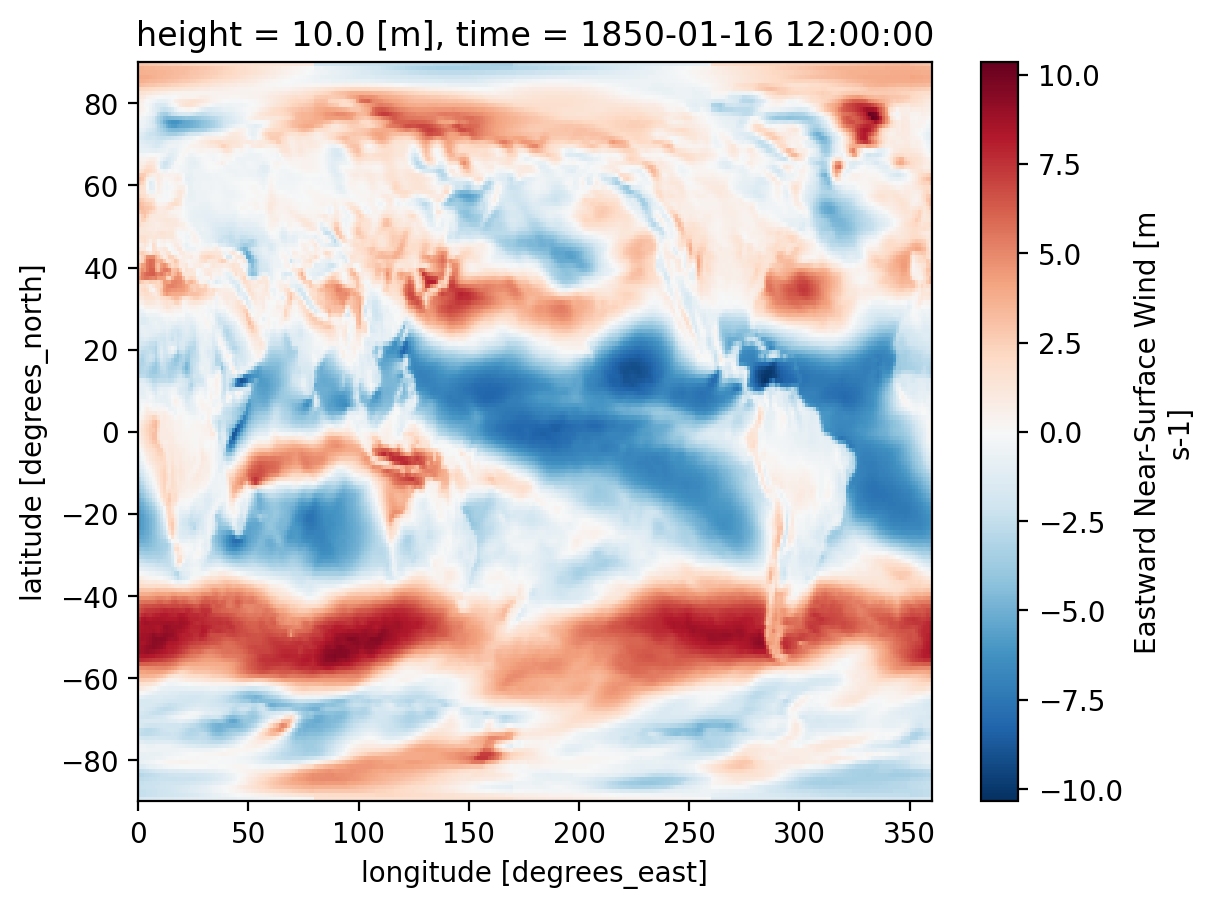

In [63]:
Uas_historical.isel(time=0).plot()

In [73]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_v_historical = df_vas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'vas'& table_id == 'Amon'")

# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_historical = xr.open_zarr(mapper, consolidated=True)

historical_vas=ds_vas_historical.vas
historical_vas

<xarray.DataArray 'vas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-vas, shape=(1980, 180, 288), dtype=float32, chunksize=(298, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

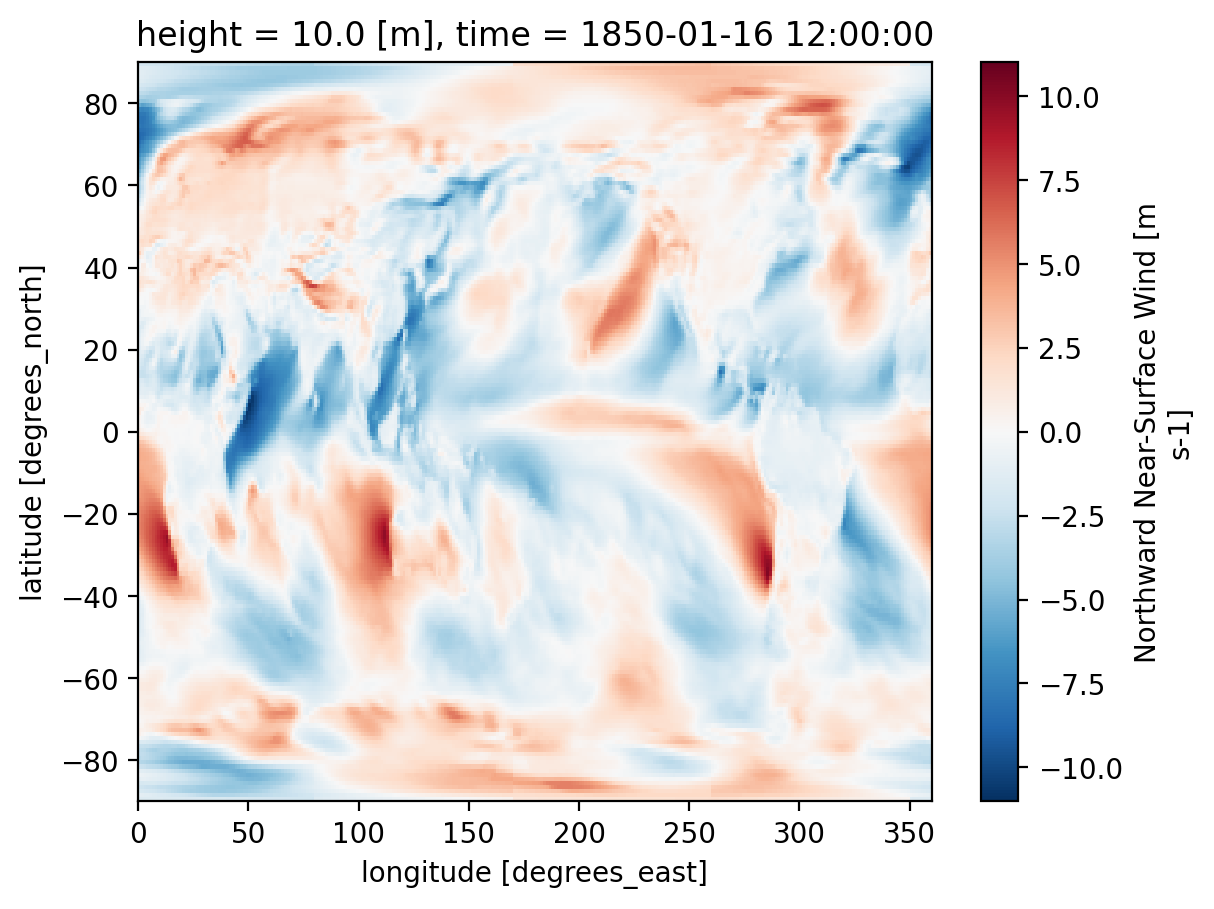

In [65]:
historical_vas.isel(time=0).plot() #verifying the wind speed was measured at 10 meters

In [66]:
#slicing into seasons and averaging it, also selecting south pole region 
vas_his_seasonal=historical_vas.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
vas_his_seasonal
uas_his_seasonal=Uas_historical.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
uas_his_seasonal

<xarray.DataArray 'uas' (season: 4, lat: 35, lon: 288)>
dask.array<getitem, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [74]:
#extracting just uas and vas data and slicing south pole lat and time 
Uas_historical1 = ds_uas_historical_use.uas.sel(time=slice('1995-01-16','2014-12-16'))
historical_vas1=ds_vas_historical.vas.sel(time=slice('1995-01-16','2014-12-16'))
Uas_historical1

<xarray.DataArray 'uas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(150, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [75]:
# merging u and v component into one dataset
his_mergewinds = xr.merge([Uas_historical1,historical_vas1]) # merge uas and vas components 
cm4_his_xmerge = his_mergewinds.lon #extracting the lon component from the mergewinds array
cm4_his_ymerge = his_mergewinds.lat
cm4_his_umerge = his_mergewinds.uas 
cm4_his_vmerge = his_mergewinds.vas
cm4_his_speedmerge = np.sqrt(np.square(cm4_his_umerge) + np.square(cm4_his_vmerge)) ## calculating speed using vector formula

## time average
timeaveragemerge = his_mergewinds.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time')
timeaveragemerge

#averaging time of speedmerge to use as overall wind speed
#speedslice = speedmerge.mean(dim='time')

## UAS seasonal dataset
#uas_his_seasonal

## VAS seasonal plot
#vas_his_seasonal

## merging the UAS seasonal and Vas seasonal to get merge seasonal
#his_seasonalmerge = xr.merge([uas_his_seasonal,vas_his_seasonal])
#his_seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [69]:
## calculating the seasonal wind speed
seasonal_speedmerge = np.sqrt(np.square(his_seasonalmerge.uas) + np.square(his_seasonalmerge.vas))

## slicing the summer speed
Summer_szn_speed = seasonal_speedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
Summer_szn= his_seasonalmerge.sel(season='DJF')

## slicing seasonalspeed to get speed for winter and averaging it
Winter_szn_speed = seasonal_speedmerge.sel(season=slice('JJA')).mean(dim='season')
Winter_szn= his_seasonalmerge.sel(season='JJA')

## FALL seasonal speed merge and averaging
Fall_szn_speed = seasonal_speedmerge.sel(season=slice('MAM')).mean(dim='season')
Fall_szn= his_seasonalmerge.sel(season='MAM')

## slicing seasonalspeed to get spring values and averaging it
Spring_szn_speed = seasonal_speedmerge.sel(season=slice('SON')).mean(dim='season')
Spring_szn= his_seasonalmerge.sel(season='SON')

NameError: name 'his_seasonalmerge' is not defined

In [76]:
lat_CM4_computed = cm4_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_computed = cm4_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4_computed,lon_CM4_computed)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_computed = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_his_speedmerge.coords['lat'],\
                                                        cm4_his_speedmerge.coords['lon']))

In [77]:
weights_cm4_computed=areacell_CM4_computed

In [78]:
weight_ross_CM4_historical_comp=(mask_CM4.ross_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_filchner_CM4_historical_comp=(mask_CM4.filchner_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_peninsula_CM4_historical_comp= (mask_CM4.peninsula_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_loweast_CM4_historical_comp= (mask_CM4.loweast_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_lowwest_CM4_historical_comp= (mask_CM4.lowwest_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_plateau_CM4_historical_comp= (mask_CM4.plateau_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])

In [79]:
weight_ross_cm4_annual_historical_comp = ml.util.annual_average(weight_ross_CM4_historical_comp,tcoord='time')
weight_filchner_cm4_annual_historical_comp= ml.util.annual_average(weight_filchner_CM4_historical_comp, tcoord='time')
weight_peninsula_cm4_annual_historical_comp=ml.util.annual_average(weight_peninsula_CM4_historical_comp, tcoord='time')
weight_loweast_cm4_annual_historical_comp=ml.util.annual_average(weight_loweast_CM4_historical_comp, tcoord='time')
weight_lowwest_cm4_annual_historical_comp=ml.util.annual_average(weight_lowwest_CM4_historical_comp, tcoord='time')
weight_plateau_cm4_annual_historical_comp=ml.util.annual_average(weight_plateau_CM4_historical_comp, tcoord='time')

In [80]:
cm4_his_ross_wind_comp=weight_ross_cm4_annual_historical_comp.mean(dim='time')
cm4_his_filch_wind_comp=weight_filchner_cm4_annual_historical_comp.mean(dim='time')
cm4_his_pen_wind_comp=weight_peninsula_cm4_annual_historical_comp.mean(dim='time')
cm4_his_east_wind_comp=weight_loweast_cm4_annual_historical_comp.mean(dim='time')
cm4_his_west_wind_comp=weight_lowwest_cm4_annual_historical_comp.mean(dim='time')
cm4_his_plat_wind_comp=weight_plateau_cm4_annual_historical_comp.mean(dim='time')

In [81]:
print(cm4_his_ross_wind_comp.values)
print(cm4_his_filch_wind_comp.values)
print(cm4_his_pen_wind_comp.values)
print(cm4_his_east_wind_comp.values)
print(cm4_his_west_wind_comp.values)
print(cm4_his_plat_wind_comp.values)

2.652426617888736
2.3462811863304864
3.084939075764785
6.816924915195285
4.4290815037601075
4.836539051129336


In [82]:
ross_total_std_CM4_comp= weight_ross_cm4_annual_historical_comp.std('time')
filchner_total_std_CM4_comp= weight_filchner_cm4_annual_historical_comp.std('time')
peninsula_total_std_CM4_comp=weight_peninsula_cm4_annual_historical_comp.std('time')
loweast_total_std_CM4_comp=weight_loweast_cm4_annual_historical_comp.std('time')
lowwest_total_std_CM4_comp=weight_lowwest_cm4_annual_historical_comp.std('time')
plateau_total_std_CM4_comp=weight_plateau_cm4_annual_historical_comp.std('time')

In [83]:
print(ross_total_std_CM4_comp.values)
print(filchner_total_std_CM4_comp.values)
print(peninsula_total_std_CM4_comp.values)
print(loweast_total_std_CM4_comp.values)
print(lowwest_total_std_CM4_comp.values)
print(plateau_total_std_CM4_comp.values)

0.1438511021082609
0.11699910524373235
0.17684365396473753
0.062112135475135284
0.1008798676797807
0.05667772602999289


# the downloaded wind speed has higher values than the calculated wind speed from the u and v components. they are closer to the era5 data though

In [ ]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = [5.1637974,
4.2680964,
5.9914885,
6.9997835,
3.887733,
7.0219145]
ERA5 = [8.637709,
8.023329,
8.4173155,
9.360203,
7.8669825,
8.49571]
# the era5 numbers are from my historical notebook. i just copied and pasted them over to cut down on loading time.  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ERA5, 0.4, label = 'downloaded ERA5', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'downloaded CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Downloaded Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = [4.5343966,
2.9753473,
5.406358,
6.578784,
2.431819,
3.6770608]
ERA5 = [8.637709,
8.023329,
8.4173155,
9.360203,
7.8669825,
8.49571]
# the era5 numbers are from my historical notebook. i just copied and pasted them over to cut down on loading time. 
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ERA5, 0.4, label = 'downloaded ERA5', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'computed CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Computed Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# esm4 wind speed variable 

In [84]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'sfcWind' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)

In [85]:
esm4_wind_speed=esm4_uas.sfcWind

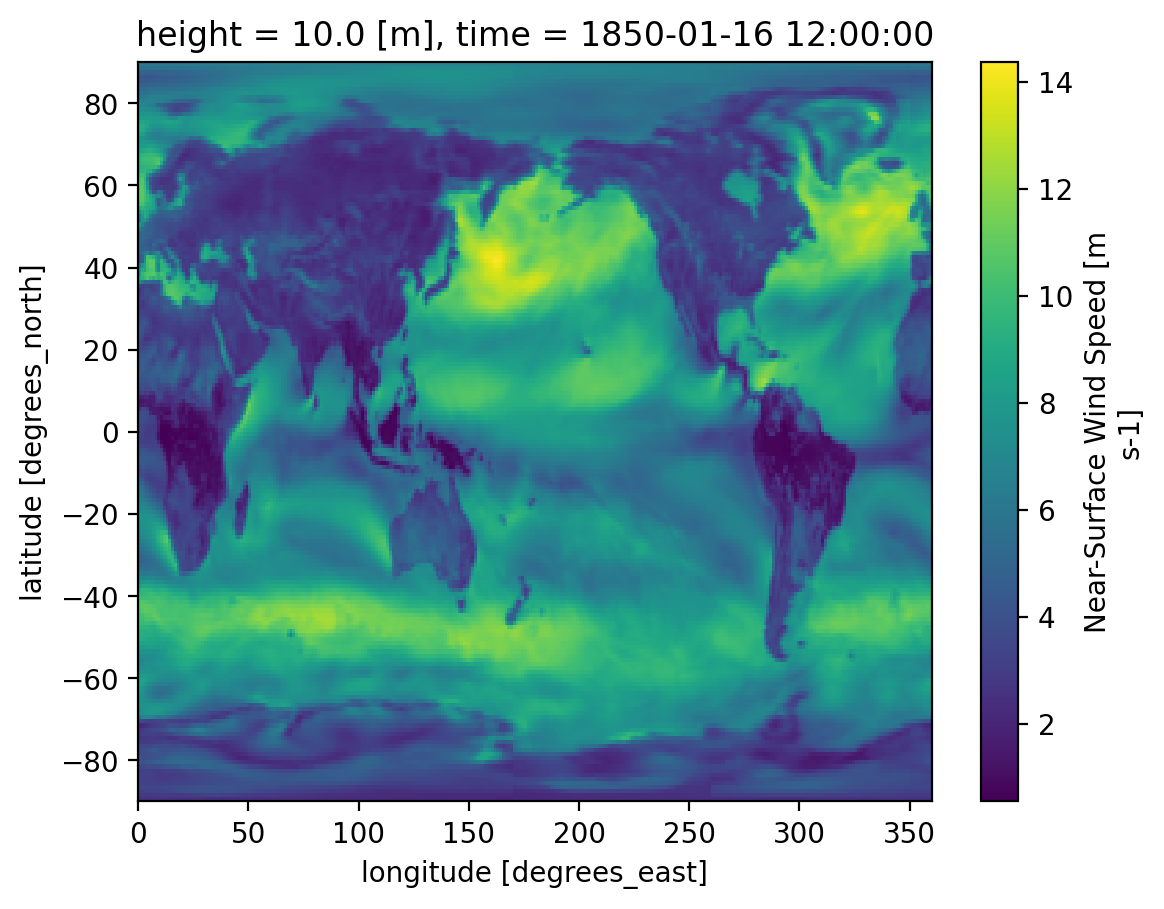

In [86]:
esm4_wind_speed.isel(time=0).plot()

In [87]:
#slicing time, averaging it, and slicing for the south pole lats
overall_esm4_speed_95_2014=esm4_wind_speed.sel(time=slice('1995-01-16','2014-12-16'))
overall_esm4_speed_95_2014

<xarray.DataArray 'sfcWind' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(222, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [89]:
lat_esm4_historical = overall_esm4_speed_95_2014.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_historical = overall_esm4_speed_95_2014.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_his_areacell = standard_grid_cell_area(lat_esm4_historical,lon_esm4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_historical = xr.DataArray(esm4_his_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(overall_esm4_speed_95_2014.coords['lat'],\
                                                        overall_esm4_speed_95_2014.coords['lon']))

In [90]:
weights_esm4_his=areacell_esm4_historical

In [91]:
weight_ross_ESM4_historical=(mask_ESM4.ross_ESM4*overall_esm4_speed_95_2014).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_filchner_ESM4_historical=(mask_ESM4.filchner_ESM4*overall_esm4_speed_95_2014).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_peninsula_ESM4_historical= (mask_ESM4.peninsula_ESM4*overall_esm4_speed_95_2014).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_loweast_ESM4_historical= (mask_ESM4.loweast_ESM4*overall_esm4_speed_95_2014).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_lowwest_ESM4_historical= (mask_ESM4.lowwest_ESM4*overall_esm4_speed_95_2014).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_plateau_ESM4_historical= (mask_ESM4.plateau_ESM4*overall_esm4_speed_95_2014).weighted(weights_esm4_his).mean(dim=['lat','lon'])

In [92]:
weight_ross_ESM4_annual_historical = ml.util.annual_average(weight_ross_ESM4_historical,tcoord='time')
weight_filchner_ESM4_annual_historical= ml.util.annual_average(weight_filchner_ESM4_historical, tcoord='time')
weight_peninsula_ESM4_annual_historical=ml.util.annual_average(weight_peninsula_ESM4_historical, tcoord='time')
weight_loweast_ESM4_annual_historical=ml.util.annual_average(weight_loweast_ESM4_historical, tcoord='time')
weight_lowwest_ESM4_annual_historical=ml.util.annual_average(weight_lowwest_ESM4_historical, tcoord='time')
weight_plateau_ESM4_annual_historical=ml.util.annual_average(weight_plateau_ESM4_historical, tcoord='time')

In [93]:
ESM4_historical_ross_wind=weight_ross_ESM4_annual_historical.mean(dim='time')
ESM4_historical_filch_wind=weight_filchner_ESM4_annual_historical.mean(dim='time')
ESM4_historical_pen_wind=weight_peninsula_ESM4_annual_historical.mean(dim='time')
ESM4_historical_east_wind=weight_loweast_ESM4_annual_historical.mean(dim='time')
ESM4_historical_west_wind=weight_lowwest_ESM4_annual_historical.mean(dim='time')
ESM4_historical_plat_wind=weight_plateau_ESM4_annual_historical.mean(dim='time')

In [94]:
print(ESM4_historical_ross_wind.values)
print(ESM4_historical_filch_wind.values)
print(ESM4_historical_pen_wind.values)
print(ESM4_historical_east_wind.values)
print(ESM4_historical_west_wind.values)
print(ESM4_historical_plat_wind.values)

4.347344685416635
3.920101180398144
6.4176670268881555
7.346535395099229
5.365843831152399
5.5366220545972675


In [95]:
ross_total_std_ESM4= weight_ross_ESM4_annual_historical.std('time')
filchner_total_std_ESM4= weight_filchner_ESM4_annual_historical.std('time')
peninsula_total_std_ESM4=weight_peninsula_ESM4_annual_historical.std('time')
loweast_total_std_ESM4=weight_loweast_ESM4_annual_historical.std('time')
lowwest_total_std_ESM4=weight_lowwest_ESM4_annual_historical.std('time')
plateau_total_std_ESM4=weight_plateau_ESM4_annual_historical.std('time')

In [96]:
print(ross_total_std_ESM4.values)
print(filchner_total_std_ESM4.values)
print(peninsula_total_std_ESM4.values)
print(loweast_total_std_ESM4.values)
print(lowwest_total_std_ESM4.values)
print(plateau_total_std_ESM4.values)

0.11735916193026984
0.12088841393742635
0.16665733565566837
0.06898468804757175
0.07592770971870798
0.06320599812264728


# esm4 computed wind speed data

In [97]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)

#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True)

In [98]:
uase4=esm4_uas.uas.sel(time=slice('1995-01-16','2014-12-16')) #eastward wind variable
vase4 = esm4_vas.vas.sel(time=slice('1995-01-16','2014-12-16')) #northward wind variable

In [99]:
mergedwindse4 = xr.merge([uase4,vase4])
esm4_xmerge=mergedwindse4.lon
esm4_ymerge=mergedwindse4.lat
esm4_umerge=mergedwindse4.uas
esm4_vmerge=mergedwindse4.vas
esm4_speed_merge=np.sqrt(np.square(esm4_umerge) + np.square(esm4_vmerge))
esm4_speed_merge
#wind speed around antarctica 

esm4_timeaveragemerge = mergedwindse4.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time')
esm4_timeaveragemerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [100]:
lat_esm4_historical_comp = esm4_speed_merge.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_historical_comp = esm4_speed_merge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_his_areacell_comp = standard_grid_cell_area(lat_esm4_historical_comp,lon_esm4_historical_comp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_historical_comp = xr.DataArray(esm4_his_areacell_comp,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_speed_merge.coords['lat'],\
                                                        esm4_speed_merge.coords['lon']))

In [101]:
weights_esm4_his_comp=areacell_esm4_historical_comp

In [102]:
weight_ross_ESM4_historical_comp=(mask_ESM4.ross_ESM4*esm4_speed_merge).weighted(weights_esm4_his_comp).mean(dim=['lat','lon'])
weight_filchner_ESM4_historical_comp=(mask_ESM4.filchner_ESM4*esm4_speed_merge).weighted(weights_esm4_his_comp).mean(dim=['lat','lon'])
weight_peninsula_ESM4_historical_comp= (mask_ESM4.peninsula_ESM4*esm4_speed_merge).weighted(weights_esm4_his_comp).mean(dim=['lat','lon'])
weight_loweast_ESM4_historical_comp= (mask_ESM4.loweast_ESM4*esm4_speed_merge).weighted(weights_esm4_his_comp).mean(dim=['lat','lon'])
weight_lowwest_ESM4_historical_comp= (mask_ESM4.lowwest_ESM4*esm4_speed_merge).weighted(weights_esm4_his_comp).mean(dim=['lat','lon'])
weight_plateau_ESM4_historical_comp= (mask_ESM4.plateau_ESM4*esm4_speed_merge).weighted(weights_esm4_his_comp).mean(dim=['lat','lon'])

In [103]:
weight_ross_ESM4_annual_historical_comp = ml.util.annual_average(weight_ross_ESM4_historical_comp,tcoord='time')
weight_filchner_ESM4_annual_historical_comp= ml.util.annual_average(weight_filchner_ESM4_historical_comp, tcoord='time')
weight_peninsula_ESM4_annual_historical_comp=ml.util.annual_average(weight_peninsula_ESM4_historical_comp, tcoord='time')
weight_loweast_ESM4_annual_historical_comp=ml.util.annual_average(weight_loweast_ESM4_historical_comp, tcoord='time')
weight_lowwest_ESM4_annual_historical_comp=ml.util.annual_average(weight_lowwest_ESM4_historical_comp, tcoord='time')
weight_plateau_ESM4_annual_historical_comp=ml.util.annual_average(weight_plateau_ESM4_historical_comp, tcoord='time')

In [104]:
ESM4_historical_comp_ross_wind=weight_ross_ESM4_annual_historical_comp.mean(dim='time')
ESM4_historical_comp_filch_wind=weight_filchner_ESM4_annual_historical_comp.mean(dim='time')
ESM4_historical_comp_pen_wind=weight_peninsula_ESM4_annual_historical_comp.mean(dim='time')
ESM4_historical_comp_east_wind=weight_loweast_ESM4_annual_historical_comp.mean(dim='time')
ESM4_historical_comp_west_wind=weight_lowwest_ESM4_annual_historical_comp.mean(dim='time')
ESM4_historical_comp_plat_wind=weight_plateau_ESM4_annual_historical_comp.mean(dim='time')

In [105]:
print(ESM4_historical_comp_ross_wind.values)
print(ESM4_historical_comp_filch_wind.values)
print(ESM4_historical_comp_pen_wind.values)
print(ESM4_historical_comp_east_wind.values)
print(ESM4_historical_comp_west_wind.values)
print(ESM4_historical_comp_plat_wind.values)

2.717323193980317
2.413653711220919
3.2008522669365895
6.944507789949228
4.556693396811866
4.876263966612993


In [106]:
ross_total_std_ESM4_comp= weight_ross_ESM4_annual_historical_comp.std('time')
filchner_total_std_ESM4_comp= weight_filchner_ESM4_annual_historical_comp.std('time')
peninsula_total_std_ESM4_comp=weight_peninsula_ESM4_annual_historical_comp.std('time')
loweast_total_std_ESM4_comp=weight_loweast_ESM4_annual_historical_comp.std('time')
lowwest_total_std_ESM4_comp=weight_lowwest_ESM4_annual_historical_comp.std('time')
plateau_total_std_ESM4_comp=weight_plateau_ESM4_annual_historical_comp.std('time')

In [107]:
print(ross_total_std_ESM4_comp.values)
print(filchner_total_std_ESM4_comp.values)
print(peninsula_total_std_ESM4_comp.values)
print(loweast_total_std_ESM4_comp.values)
print(lowwest_total_std_ESM4_comp.values)
print(plateau_total_std_ESM4_comp.values)

0.12827888028683546
0.1112760032392988
0.1301968465953218
0.0924209210316265
0.10579032034074715
0.09259222616016305


# era5 computed wind speed

In [108]:
era5_vas=xr.open_dataset(('/home/tu.temple.edu/tuo15329/era5_wind/era5_10m_v_component_of_wind_1940-2024_monthly_ensemble.nc'),use_cftime=True)
era5_vas_noleap=era5_vas.assign_attrs(calendar='noleap')
era5_vas_use =era5_vas_noleap.mean(dim='expver')
era5_vas_use

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 1013)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1940-01-01 00:00:00 ... 2024-05-01 00:00:00
Data variables:
    v10        (time, number, latitude, longitude) float32 -0.8757 ... 2.342

In [109]:
ERA5_vas_95_2014=era5_vas_use.v10.mean(dim='number').sel(time=slice('1995-01-01','2014-12-01'))
ERA5_vas_95_2014

<xarray.DataArray 'v10' (time: 240, latitude: 361, longitude: 720)>
array([[[ 7.3742932e-01,  7.3742932e-01,  7.3742932e-01, ...,
          7.3742932e-01,  7.3742932e-01,  7.3742932e-01],
        [-2.4880266e-01, -2.4975987e-01, -2.5066391e-01, ...,
         -2.4444208e-01, -2.4585128e-01, -2.4734028e-01],
        [-2.8211844e-01, -2.8310218e-01, -2.8491026e-01, ...,
         -2.7491289e-01, -2.7770472e-01, -2.8057629e-01],
        ...,
        [ 1.9084325e-01,  1.8236142e-01,  1.7029010e-01, ...,
          2.3069987e-01,  2.1620896e-01,  2.0177123e-01],
        [ 2.3798521e-01,  2.3171024e-01,  2.2543530e-01, ...,
          2.5976142e-01,  2.5250268e-01,  2.4527054e-01],
        [ 8.3200568e-01,  8.3200568e-01,  8.3200568e-01, ...,
          8.3200568e-01,  8.3200568e-01,  8.3200568e-01]],

       [[ 8.5332996e-01,  8.5332996e-01,  8.5332996e-01, ...,
          8.5332996e-01,  8.5332996e-01,  8.5332996e-01],
        [ 8.6801253e-02,  9.1321349e-02,  9.5788255e-02, ...,
          7.6910183e-02,  8.0154039e-02,  8.3477654e-02],
        [ 2.0276058e-02,  2.7455043e-02,  3.6309086e-02, ...,
          1.7170549e-03,  8.2047461e-03,  1.4772189e-02],
...
        [ 2.5655959e+00,  2.5734131e+00,  2.5811768e+00, ...,
          1.7977909e+00,  1.8042253e+00,  1.8107131e+00],
        [ 1.8171209e+00,  1.8234227e+00,  1.8295380e+00, ...,
          1.7066710e+00,  1.7205769e+00,  1.7344033e+00],
        [ 1.7482029e+00,  1.7619756e+00,  1.7756956e+00, ...,
          8.9488810e-01,  8.9488810e-01,  8.9488810e-01]],

       [[ 9.2046672e-01,  9.2046672e-01,  9.2046672e-01, ...,
          8.6936301e-01,  8.6936301e-01,  8.6936301e-01],
        [ 8.6936301e-01,  8.6936301e-01,  8.6936301e-01, ...,
          2.2701411e+00,  2.2611272e+00,  2.2522202e+00],
        [ 2.2432065e+00,  2.2342992e+00,  2.2253654e+00, ...,
          2.2462642e+00,  2.2371178e+00,  2.2279713e+00],
        ...,
        [ 2.8365886e+00,  2.8387427e+00,  2.8407636e+00, ...,
          2.3851643e+00,  2.3873179e+00,  2.3893383e+00],
        [ 2.3912530e+00,  2.3932736e+00,  2.3950553e+00, ...,
          2.2958524e+00,  2.3046002e+00,  2.3131881e+00],
        [ 2.3218827e+00,  2.3305240e+00,  2.3390326e+00, ...,
          9.2046660e-01,  9.2046660e-01,  9.2046660e-01]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00

In [110]:
era5_uas=xr.open_dataset(('/home/tu.temple.edu/tuo15329/era5_wind/era5_10m_u_component_of_wind_1940-2024_monthly_ensemble.nc'),use_cftime=True)
era5_uas_noleap=era5_uas.assign_attrs(calendar='noleap')
era5_uas_use =era5_uas_noleap.mean('expver')
era5_uas_use

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 1013)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1940-01-01 00:00:00 ... 2024-05-01 00:00:00
Data variables:
    u10        (time, number, latitude, longitude) float32 0.6144 ... -2.418

In [111]:
ERA5_uas_95_2014=era5_uas_use.sel(time=slice('1995-01-01','2014-12-01'))
ERA5_uas_95_2014

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 240)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    u10        (time, number, latitude, longitude) float32 -0.93 ... -0.5329

In [112]:
#era5 wind components 
ERA5_vas_95_2014
ERA5_uas_95_2014

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 240)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    u10        (time, number, latitude, longitude) float32 -0.93 ... -0.5329

In [113]:
ERA5_merge_winds=xr.merge([ERA5_vas_95_2014,ERA5_uas_95_2014])
xmerge = ERA5_merge_winds.longitude #extracting the lon component fomr the mergewinds array
ymerge = ERA5_merge_winds.latitude
umerge = ERA5_merge_winds.u10
vmerge = ERA5_merge_winds.v10
speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector sum formula
## average
timeaveragemerge = ERA5_merge_winds.sel(time=slice('1995-01-01','2014-12-01')).mean(dim='time')
timeaveragemerge

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    v10        (latitude, longitude) float32 0.881 0.881 0.881 ... 0.8956 0.8956
    u10        (number, latitude, longitude) float32 -0.8066 -0.8066 ... -0.4109

In [114]:
#was not getting one value for the std so meaned out number and this fixed it
test=speedmerge.mean(dim='number')
test

<xarray.DataArray (time: 240, latitude: 361, longitude: 720)>
array([[[1.1868944 , 1.1868944 , 1.1868944 , ..., 1.1868944 ,
         1.1868944 , 1.1868944 ],
        [0.71756876, 0.72198665, 0.72631633, ..., 0.7073922 ,
         0.71076906, 0.71417344],
        [0.90075666, 0.9058913 , 0.91442347, ..., 0.88307077,
         0.88967407, 0.89635056],
        ...,
        [1.9592531 , 1.954706  , 1.949202  , ..., 1.9674406 ,
         1.9650223 , 1.9627386 ],
        [1.85794   , 1.8550103 , 1.8521245 , ..., 1.8620205 ,
         1.8606247 , 1.8592348 ],
        [0.955276  , 0.955276  , 0.955276  , ..., 0.955276  ,
         0.955276  , 0.955276  ]],

       [[1.194991  , 1.194991  , 1.194991  , ..., 1.194991  ,
         1.194991  , 1.194991  ],
        [1.6422627 , 1.6460575 , 1.6498353 , ..., 1.6295159 ,
         1.6337478 , 1.6379898 ],
        [1.7161449 , 1.7216018 , 1.7287242 , ..., 1.6934189 ,
         1.7015493 , 1.7097299 ],
...
        [3.780568  , 3.7764492 , 3.7696846 , ..., 3.3342729 ,
         3.3288836 , 3.3235824 ],
        [3.167899  , 3.1648438 , 3.1617315 , ..., 3.119681  ,
         3.122733  , 3.125789  ],
        [1.8100672 , 1.8233726 , 1.836634  , ..., 1.0104225 ,
         1.0104225 , 1.0104225 ]],

       [[1.2782036 , 1.2782036 , 1.2782036 , ..., 1.2419086 ,
         1.2419086 , 1.2419086 ],
        [2.3947182 , 2.399011  , 2.4032352 , ..., 3.1715307 ,
         3.1689763 , 3.1665487 ],
        [3.1763728 , 3.1750293 , 3.1750283 , ..., 3.1571028 ,
         3.1583676 , 3.159697  ],
        ...,
        [3.5198321 , 3.5129802 , 3.5036197 , ..., 3.194296  ,
         3.1865013 , 3.1786847 ],
        [3.0328045 , 3.028697  , 3.0243938 , ..., 2.9721406 ,
         2.9742763 , 2.9762673 ],
        [2.3815243 , 2.38995   , 2.3982477 , ..., 1.061968  ,
         1.061968  , 1.061968  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00

# spatial weighting

In [115]:
lat_ERA5 = test.coords['latitude'].values #1-D numpy array of model's latitude values
lon_ERA5 = test.coords['longitude'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_ERA5,lon_ERA5)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_ERA5 = xr.DataArray(areacell,dims=({'latitude':180, 'longitude':360}),\
                                                coords=(test.coords['latitude'],\
                                                        test.coords['longitude']))

In [116]:
weights_ERA5_wind=areacell_ERA5

In [117]:
weight_ross_ERA5=(mask_ERA5.ross_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_filchner_ERA5=(mask_ERA5.filchner_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_peninsula_ERA5= (mask_ERA5.peninsula_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_loweast_ERA5= (mask_ERA5.loweast_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_lowwest_ERA5= (mask_ERA5.lowwest_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_plateau_ERA5= (mask_ERA5.plateau_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])

In [118]:
weight_ross_ERA5_annual_wind = ml.util.annual_average(weight_ross_ERA5, tcoord='time')
weight_filchner_ERA5_annual_wind= ml.util.annual_average(weight_filchner_ERA5, tcoord='time')
weight_peninsula_ERA5_annual_wind=ml.util.annual_average(weight_peninsula_ERA5, tcoord='time')
weight_loweast_ERA5_annual_wind=ml.util.annual_average(weight_loweast_ERA5, tcoord='time')
weight_lowwest_ERA5_annual_wind=ml.util.annual_average(weight_lowwest_ERA5, tcoord='time')
weight_plateau_ERA5_annual_wind=ml.util.annual_average(weight_plateau_ERA5, tcoord='time')

In [119]:
ross_wind=weight_ross_ERA5_annual_wind.mean(dim='time')
filch_wind=weight_filchner_ERA5_annual_wind.mean(dim='time')
pen_wind=weight_peninsula_ERA5_annual_wind.mean(dim='time')
east_wind=weight_loweast_ERA5_annual_wind.mean(dim='time')
west_wind=weight_lowwest_ERA5_annual_wind.mean(dim='time')
plat_wind=weight_plateau_ERA5_annual_wind.mean(dim='time')

In [120]:
print(ross_wind.values)
print(filch_wind.values)
print(pen_wind.values)
print(east_wind.values)
print(west_wind.values)
print(plat_wind.values)

2.0541219718707366
2.261370707221682
2.0622170744754036
3.879573766002976
3.4623717554675686
3.290086151241666


# standard deviation 

In [121]:
ross_total_std_ERA5= weight_ross_ERA5_annual_wind.std('time')
filchner_total_std_ERA5= weight_filchner_ERA5_annual_wind.std('time')
peninsula_total_std_ERA5=weight_peninsula_ERA5_annual_wind.std('time')
loweast_total_std_ERA5=weight_loweast_ERA5_annual_wind.std('time')
lowwest_total_std_ERA5=weight_lowwest_ERA5_annual_wind.std('time')
plateau_total_std_ERA5=weight_plateau_ERA5_annual_wind.std('time')

In [122]:
print(ross_total_std_ERA5.values)
print(filchner_total_std_ERA5.values)
print(peninsula_total_std_ERA5.values)
print(loweast_total_std_ERA5.values)
print(lowwest_total_std_ERA5.values)
print(plateau_total_std_ERA5.values)

0.1862190909768641
0.11528699976409783
0.15290147555709413
0.46160155346448595
0.18986837028166756
0.16606948611360867


# era5 instantaneous wind 

In [35]:
era5_windspeed=xr.open_dataset(('/home/tu.temple.edu/tuo15329/era5_wind/era5_10m_wind_speed_1940-2024_monthly_ensemble.nc'),use_cftime=True)
ERA5_windspeed_noleap=era5_windspeed.assign_attrs(calendar='noleap')
era5_windspeed_use =ERA5_windspeed_noleap.mean('expver')
era5_windspeed_use

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 1013)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1940-01-01 00:00:00 ... 2024-05-01 00:00:00
Data variables:
    si10       (time, number, latitude, longitude) float32 6.298 6.298 ... 9.893

In [49]:
ERA5_instant_wind=era5_windspeed_use.si10.mean(dim='number').sel(time=slice('1995-01-01','2014-12-01'))
ERA5_instant_wind

<xarray.DataArray 'si10' (time: 240, latitude: 361, longitude: 720)>
array([[[7.325742 , 7.325742 , 7.325742 , ..., 7.325742 , 7.325742 ,
         7.325742 ],
        [7.286175 , 7.286853 , 7.2875047, ..., 7.2841783, 7.284829 ,
         7.2855234],
        [7.263903 , 7.264712 , 7.2660723, ..., 7.2605767, 7.261805 ,
         7.263035 ],
        ...,
        [6.7713013, 6.7719812, 6.7746124, ..., 6.765878 , 6.76838  ,
         6.7708817],
        [6.657689 , 6.6592073, 6.6606817, ..., 6.653899 , 6.655172 ,
         6.6564164],
        [6.515976 , 6.515976 , 6.515976 , ..., 6.515976 , 6.515976 ,
         6.515976 ]],

       [[7.637338 , 7.637338 , 7.637338 , ..., 7.637338 , 7.637338 ,
         7.637338 ],
        [7.6901526, 7.689561 , 7.6889815, ..., 7.6916285, 7.6911507,
         7.6906447],
        [7.7548704, 7.75354  , 7.75234  , ..., 7.757777 , 7.756794 ,
         7.75581  ],
...
        [7.5262275, 7.4558983, 7.3777895, ..., 7.393495 , 7.376185 ,
         7.3671317],
        [7.3846016, 7.4058456, 7.4108353, ..., 7.4005675, 7.3763146,
         7.349518 ],
        [7.311251 , 7.323616 , 7.3144326, ..., 6.949125 , 6.9436865,
         6.934301 ]],

       [[7.8448668, 7.836695 , 7.831605 , ..., 8.195712 , 8.215815 ,
         8.224578 ],
        [8.246402 , 8.256365 , 8.25677  , ..., 8.017441 , 7.997411 ,
         7.9779015],
        [7.7246156, 7.740365 , 7.7408423, ..., 7.799052 , 7.7516594,
         7.71306  ],
        ...,
        [7.085009 , 7.0983133, 7.1214666, ..., 7.455494 , 7.49807  ,
         7.5347013],
        [7.555845 , 7.5664315, 7.565159 , ..., 7.868006 , 7.8781004,
         7.8271933],
        [7.9436417, 7.917392 , 7.8590684, ..., 7.829768 , 7.820325 ,
         7.8138885]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00

In [50]:
lat_ERA5_instant = ERA5_instant_wind.coords['latitude'].values #1-D numpy array of model's latitude values
lon_ERA5_instant = ERA5_instant_wind.coords['longitude'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell_era5 = standard_grid_cell_area(lat_ERA5_instant,lon_ERA5_instant)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_ERA5_instant = xr.DataArray(areacell_era5,dims=({'latitude':180, 'longitude':360}),\
                                                coords=(ERA5_instant_wind.coords['latitude'],\
                                                        ERA5_instant_wind.coords['longitude']))

In [51]:
weights_ERA5_wind_instant=areacell_ERA5_instant

In [52]:
weight_ross_ERA5_instant=(mask_ERA5.ross_ERA5*ERA5_instant_wind).weighted(weights_ERA5_wind_instant).mean(dim=['latitude','longitude'])
weight_filchner_ERA_instant=(mask_ERA5.filchner_ERA5*ERA5_instant_wind).weighted(weights_ERA5_wind_instant).mean(dim=['latitude','longitude'])
weight_peninsula_ERA5_instant= (mask_ERA5.peninsula_ERA5*ERA5_instant_wind).weighted(weights_ERA5_wind_instant).mean(dim=['latitude','longitude'])
weight_loweast_ERA5_instant= (mask_ERA5.loweast_ERA5*ERA5_instant_wind).weighted(weights_ERA5_wind_instant).mean(dim=['latitude','longitude'])
weight_lowwest_ERA5_instant= (mask_ERA5.lowwest_ERA5*ERA5_instant_wind).weighted(weights_ERA5_wind_instant).mean(dim=['latitude','longitude'])
weight_plateau_ERA5_instant= (mask_ERA5.plateau_ERA5*ERA5_instant_wind).weighted(weights_ERA5_wind_instant).mean(dim=['latitude','longitude'])

In [53]:
weight_ross_ERA5_annual_wind_instant = ml.util.annual_average(weight_ross_ERA5_instant, tcoord='time')
weight_filchner_ERA5_annual_wind_instant= ml.util.annual_average(weight_filchner_ERA_instant, tcoord='time')
weight_peninsula_ERA5_annual_wind_instant=ml.util.annual_average(weight_peninsula_ERA5_instant, tcoord='time')
weight_loweast_ERA5_annual_wind_instant=ml.util.annual_average(weight_loweast_ERA5_instant, tcoord='time')
weight_lowwest_ERA5_annual_wind_instant=ml.util.annual_average(weight_lowwest_ERA5_instant, tcoord='time')
weight_plateau_ERA5_annual_wind_instant=ml.util.annual_average(weight_plateau_ERA5_instant, tcoord='time')

In [54]:
ross_wind_instant=weight_ross_ERA5_annual_wind_instant.mean(dim='time')
filch_wind_instant=weight_filchner_ERA5_annual_wind_instant.mean(dim='time')
pen_wind_instant=weight_peninsula_ERA5_annual_wind_instant.mean(dim='time')
east_wind_instant=weight_loweast_ERA5_annual_wind_instant.mean(dim='time')
west_wind_instant=weight_lowwest_ERA5_annual_wind_instant.mean(dim='time')
plat_wind_instant=weight_plateau_ERA5_annual_wind_instant.mean(dim='time')

In [55]:
print(ross_wind_instant.values)
print(filch_wind_instant.values)
print(pen_wind_instant.values)
print(east_wind_instant.values)
print(west_wind_instant.values)
print(plat_wind_instant.values)

7.465045736341544
7.418516132835971
7.576608630802316
8.218877608064716
7.771624417220201
7.928714856626169


In [57]:
ross_total_std_ERA5_instant= weight_ross_ERA5_annual_wind_instant.std('time')
filchner_total_std_ERA5_instant= weight_filchner_ERA5_annual_wind_instant.std('time')
peninsula_total_std_ERA5_instant=weight_peninsula_ERA5_annual_wind_instant.std('time')
loweast_total_std_ERA5_instant=weight_loweast_ERA5_annual_wind_instant.std('time')
lowwest_total_std_ERA5_instant=weight_lowwest_ERA5_annual_wind_instant.std('time')
plateau_total_std_ERA5_instant=weight_plateau_ERA5_annual_wind_instant.std('time')

In [59]:
print(ross_total_std_ERA5_instant.values)
print(filchner_total_std_ERA5_instant.values)
print(peninsula_total_std_ERA5_instant.values)
print(loweast_total_std_ERA5_instant.values)
print(lowwest_total_std_ERA5_instant.values)
print(plateau_total_std_ERA5_instant.values)

0.05952926070682917
0.09844620552877964
0.1348792996528249
0.8546145902541082
0.3379881820397745
0.5168479030681734


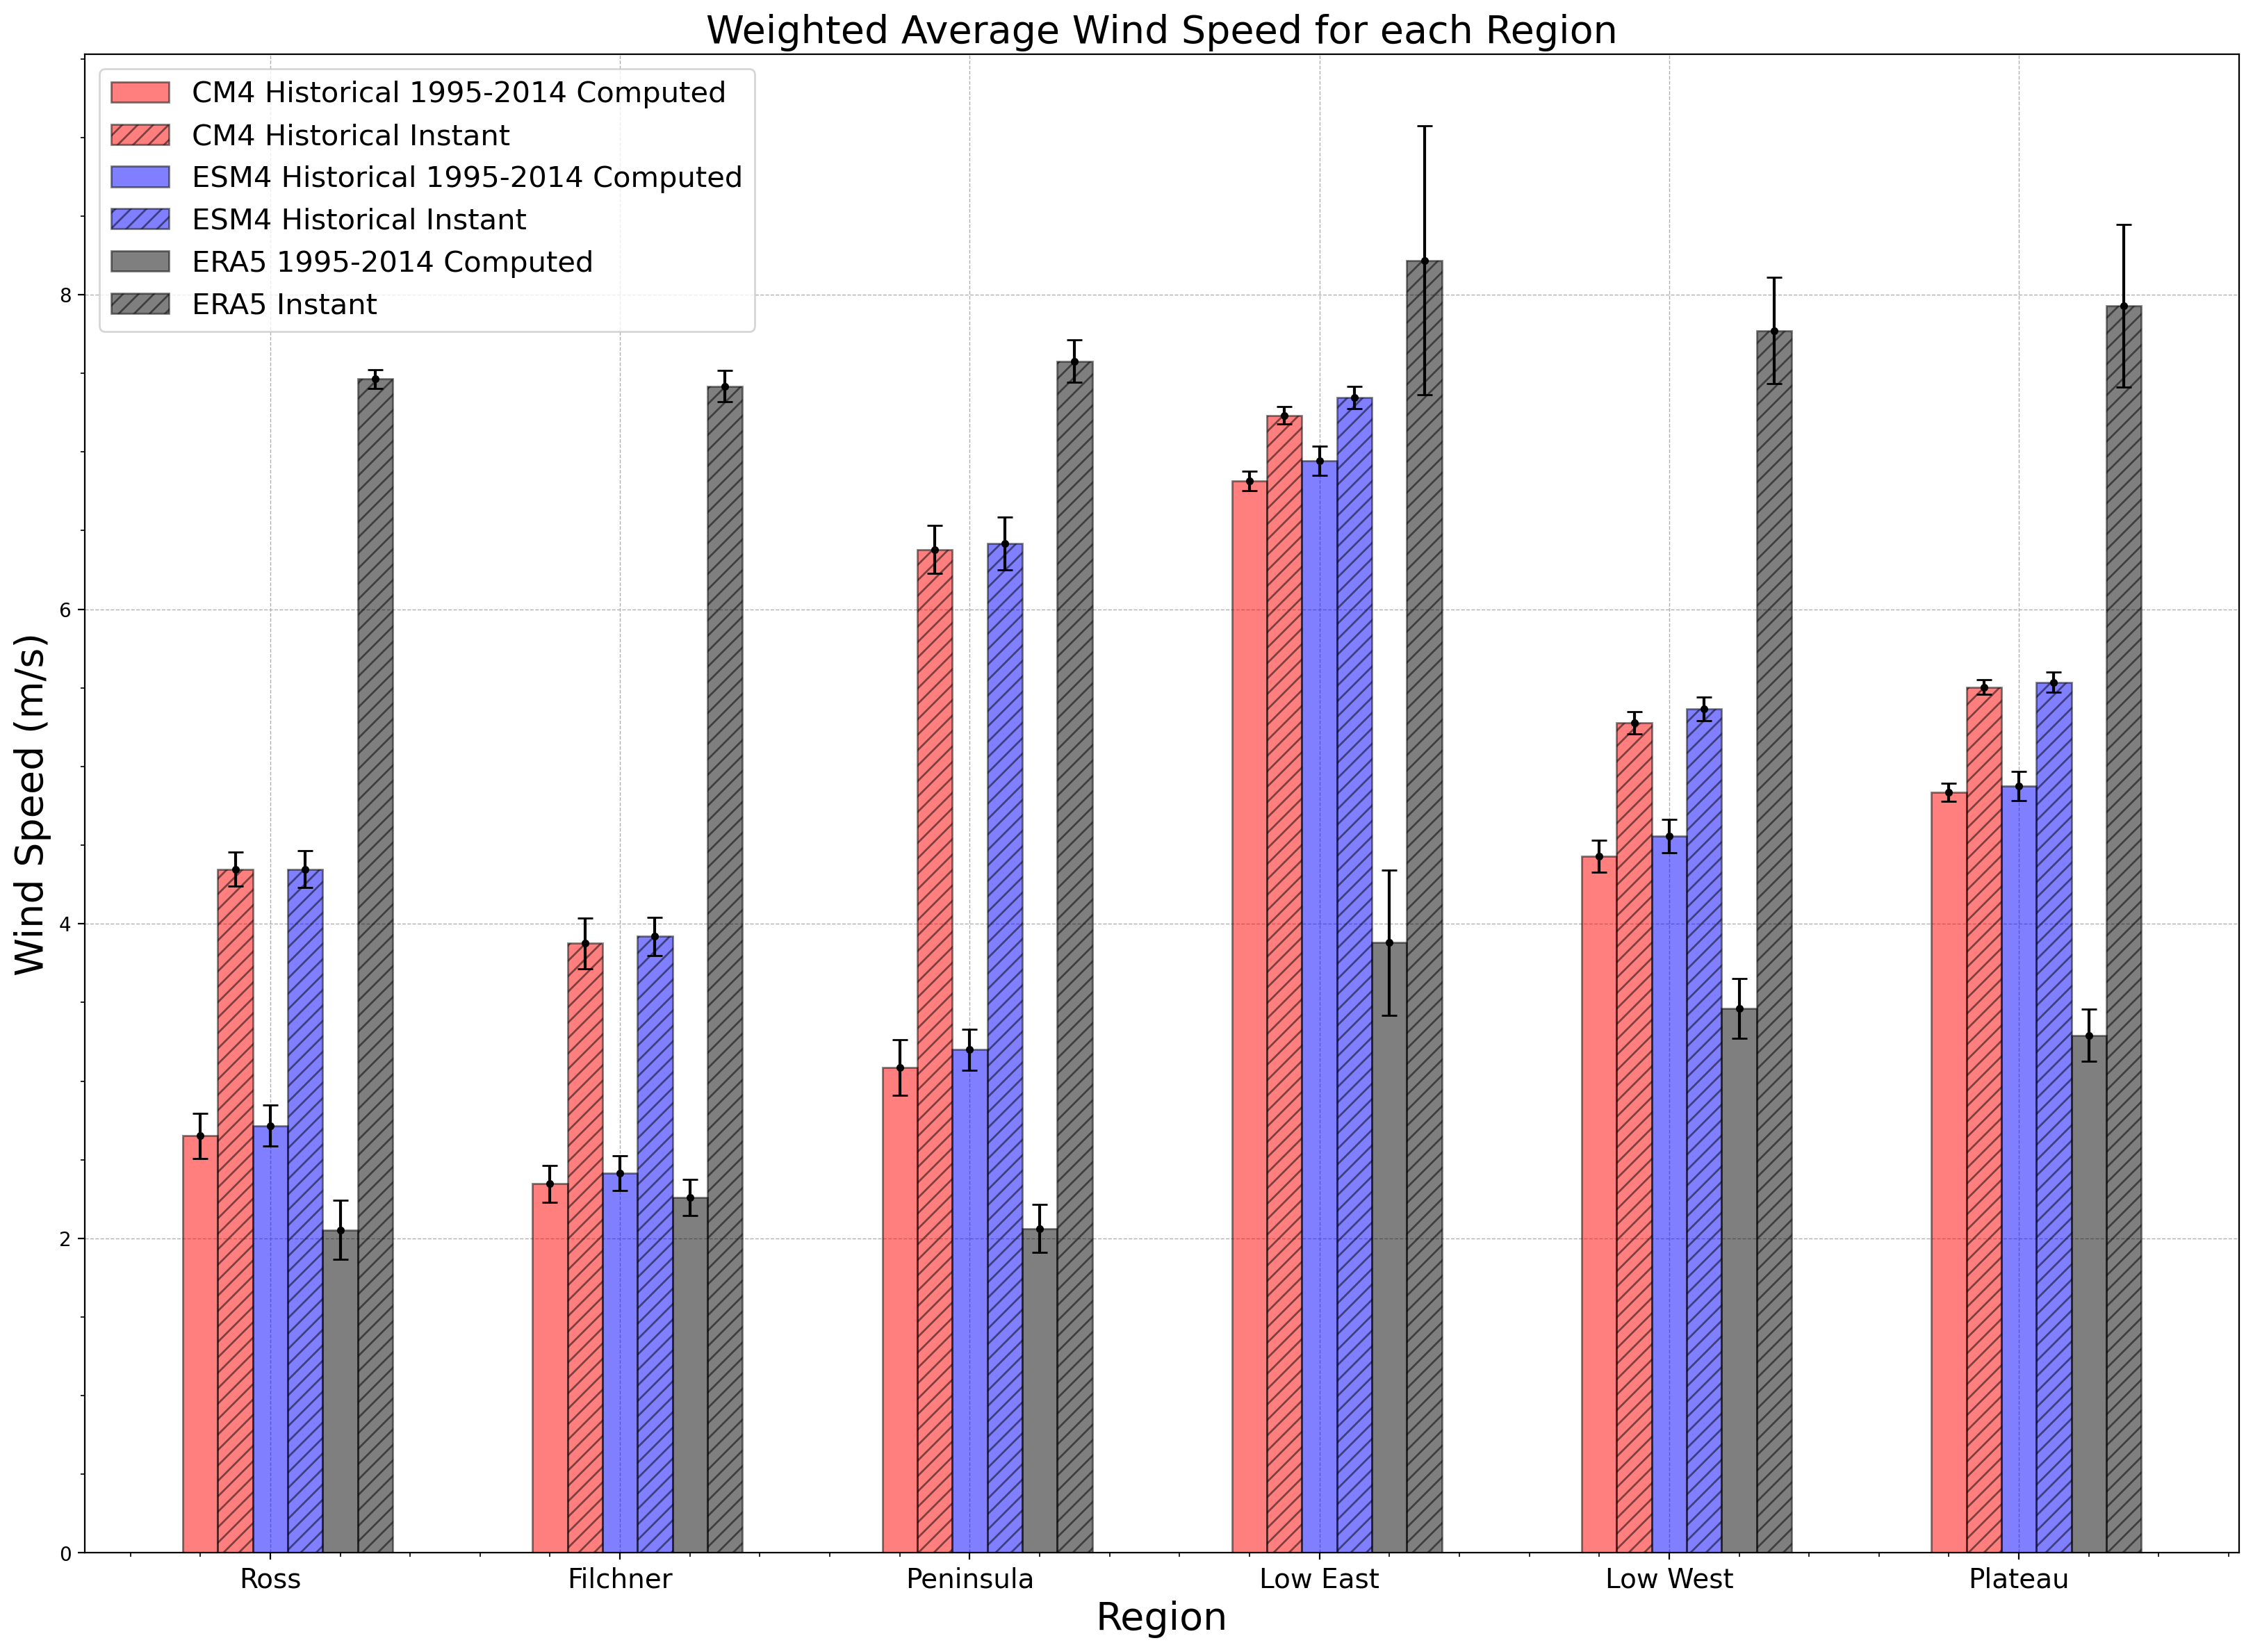

In [128]:
fig, ax= plt.subplots(figsize= (20,14))

X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 
Historical_CM4_computed = [2.652426617888736,
2.3462811863304864,
3.084939075764785,
6.816924915195285,
4.4290815037601075,
4.836539051129336] 

Historical_CM4_instant=[4.346922679053895,
3.8759635152701066,
6.380655790666305,
7.232140290915028,
5.276680620375986,
5.505219052453639]

Historical_ESM4_computed = [2.717323193980317,
2.413653711220919,
3.2008522669365895,
6.944507789949228,
4.556693396811866,
4.876263966612993] 

Historical_ESM4_instant=[4.347344685416635,
3.920101180398144,
6.4176670268881555,
7.346535395099229,
5.365843831152399,
5.5366220545972675]

ERA5_computed = [2.0541219718707366,
2.261370707221682,
2.0622170744754036,
3.879573766002976,
3.4623717554675686,
3.290086151241666]

ERA5_instant = [7.465045736341544,
7.418516132835971,
7.576608630802316,
8.218877608064716,
7.771624417220201,
7.928714856626169]

std_cm4_computed=[0.1438511021082609,
0.11699910524373235,
0.17684365396473753,
0.062112135475135284,
0.1008798676797807,
0.05667772602999289]

std_cm4_instant=[0.10914607768235833,
0.16174650412815672,
0.15050178960639204,
0.05596676717319086,
0.07039177571198384,
0.04606005054890751]

std_esm4_computed= [0.12827888028683546,
0.1112760032392988,
0.1301968465953218,
0.0924209210316265,
0.10579032034074715,
0.09259222616016305]

std_esm4_instant = [0.11735916193026984,
0.12088841393742635,
0.16665733565566837,
0.06898468804757175,
0.07592770971870798,
0.06320599812264728]

std_era5_computed= [0.1862190909768641,
0.11528699976409783,
0.15290147555709413,
0.46160155346448595,
0.18986837028166756,
0.16606948611360867]


std_era5_instant=[0.05952926070682917,
0.09844620552877964,
0.1348792996528249,
0.8546145902541082,
0.3379881820397745,
0.5168479030681734]


X_axis = np.arange(len(X)) 

plt.bar(X_axis-0.2, Historical_CM4_computed, 0.1, label = 'CM4 Historical 1995-2014 Computed', color='r',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis-0.2, Historical_CM4_computed,yerr= std_cm4_computed,fmt='o', color= 'black', markersize=3, capsize=4)

plt.bar(X_axis-0.1, Historical_CM4_instant, 0.1, label= 'CM4 Historical Instant', color ='r', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis-0.1, Historical_CM4_instant, yerr= std_cm4_instant, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis, Historical_ESM4_computed, 0.1, label = 'ESM4 Historical 1995-2014 Computed', color= 'blue',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis, Historical_ESM4_computed, yerr=std_esm4_computed, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.1,Historical_ESM4_instant, 0.1, label='ESM4 Historical Instant', color='blue', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.1, Historical_ESM4_instant, yerr= std_esm4_instant, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.2, ERA5_computed, 0.1, label= 'ERA5 1995-2014 Computed', color='k', alpha=0.5,edgecolor='black')
plt.errorbar(X_axis+0.2, ERA5_computed, yerr=std_era5_computed, fmt= 'o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.3, ERA5_instant, 0.1, label='ERA5 Instant', color='k', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.3, ERA5_instant, yerr= std_era5_instant, fmt='o', color='black', markersize=3, capsize=4)


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Wind Speed (m/s)", fontsize=20 )
plt.title("Weighted Average Wind Speed for each Region", fontsize=20) 
plt.legend(fontsize=15) 
ax.minorticks_on()
